# **Train a MobileNet model**

In [1]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 63.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 65.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into account

In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
import h5py
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
#for broken data stream error
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
%matplotlib inline

**Image preparation**

In [3]:
train_path = '/kaggle/input/split-folders/final_FD_images/train'
valid_path = '/kaggle/input/split-folders/final_FD_images/val'
test_path = '/kaggle/input/split-folders/final_FD_images/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=64)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=16)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=16, shuffle=False)

Found 13133 images belonging to 2 classes.
Found 1876 images belonging to 2 classes.
Found 3754 images belonging to 2 classes.


**Modify Model**

In [5]:
mobile = keras.applications.mobilenet.MobileNet()
mobile.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

In [6]:
#Deleting the last 5 layers and replacing it with a dense softmax layer consisting of 2 nodes: Fire and Non-fire
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [7]:
#Freezing weights all the layers upto the 4th last layer
#This is done because we will retrain only the last three layers
for layer in model.layers[:-4]:
    layer.trainable = False

**Train the model**

In [8]:
model.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
checkpointer = ModelCheckpoint(filepath = './model/mobile_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001)  
model.fit(train_batches, validation_data=valid_batches, epochs=15, verbose=1, callbacks=[checkpointer,reduce_lr])

Epoch 1/15
206/206 [==============================] - 154s 678ms/step - loss: 0.1615 - accuracy: 0.9424 - val_loss: 0.0321 - val_accuracy: 0.9968

Epoch 00001: val_loss improved from inf to 0.03210, saving model to ./model/mobile_model.h5
Epoch 2/15
206/206 [==============================] - 85s 415ms/step - loss: 0.0253 - accuracy: 0.9970 - val_loss: 0.0117 - val_accuracy: 0.9989

Epoch 00002: val_loss improved from 0.03210 to 0.01165, saving model to ./model/mobile_model.h5
Epoch 3/15
206/206 [==============================] - 85s 411ms/step - loss: 0.0128 - accuracy: 0.9990 - val_loss: 0.0059 - val_accuracy: 0.9995

Epoch 00003: val_loss improved from 0.01165 to 0.00592, saving model to ./model/mobile_model.h5
Epoch 4/15
206/206 [==============================] - 85s 410ms/step - loss: 0.0089 - accuracy: 0.9991 - val_loss: 0.0038 - val_accuracy: 0.9995

Epoch 00004: val_loss improved from 0.00592 to 0.00376, saving model to ./model/mobile_model.h5
Epoch 5/15
206/206 [===============

In [10]:
test_labels = test_batches.classes
print(test_labels)
print(test_batches.class_indices)

[0 0 0 ... 1 1 1]
{'fire': 0, 'nonfire': 1}


**Test Model**

In [11]:
predictions = model.predict(test_batches, verbose=1)
loss,accuracy=model.evaluate(test_batches)
print("Accuracy: ",accuracy)

235/235 [==============================] - 20s 84ms/step - loss: 8.8908e-04 - accuracy: 1.0000
Accuracy:  1.0


In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1978, 47], [64, 1665]]


AttributeError: 'list' object has no attribute 'max'

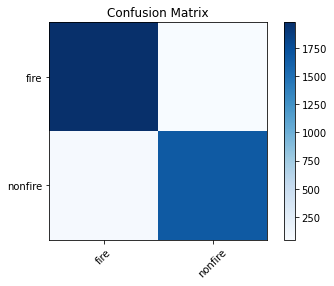

In [11]:
cm = [[1978,47],[64,1665]]
print(test_batches.class_indices)
cm_plot_labels = ['fire','nonfire']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

**Prepare image to predict**

In [14]:
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

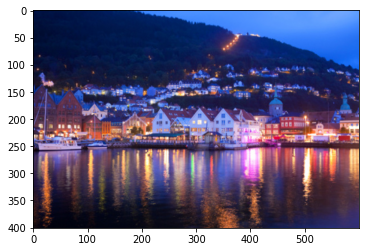

Fire : 0.64%  |Not Fire: 99.3%
No Fire detected





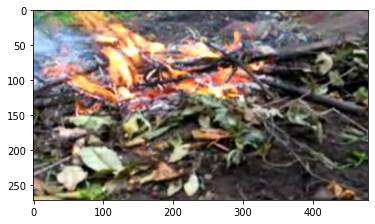

Fire : 99.9%  |Not Fire: 0.01%
Fire detected





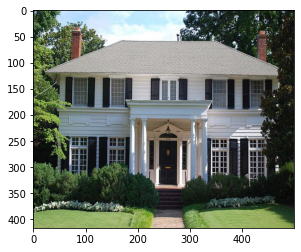

Fire : 6.42%  |Not Fire: 99.9%
No Fire detected





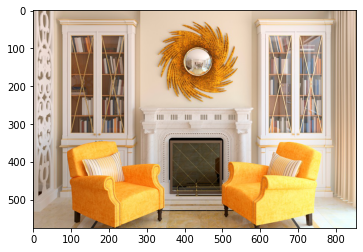

Fire : 0.00%  |Not Fire: 99.9%
No Fire detected





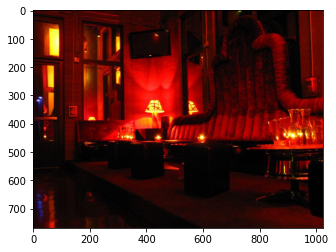

Fire : 0.01%  |Not Fire: 99.9%
No Fire detected





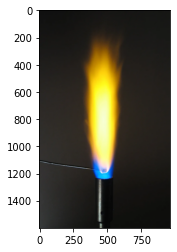

Fire : 95.1%  |Not Fire: 4.87%
Fire detected





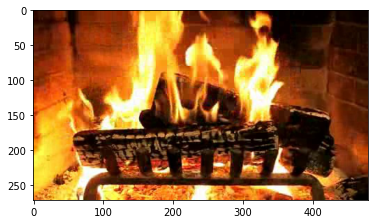

Fire : 99.9%  |Not Fire: 0.00%
Fire detected





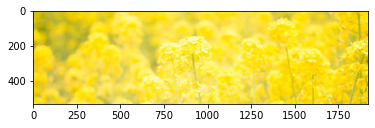

Fire : 66.2%  |Not Fire: 33.7%
Fire detected





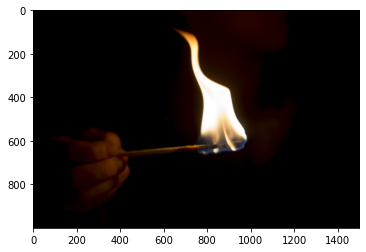

Fire : 53.0%  |Not Fire: 46.9%
Fire detected





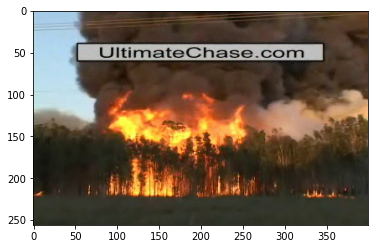

Fire : 99.9%  |Not Fire: 0.01%
Fire detected





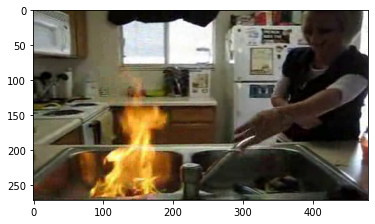

Fire : 99.9%  |Not Fire: 0.00%
Fire detected





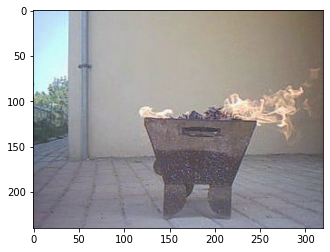

Fire : 99.9%  |Not Fire: 0.06%
Fire detected





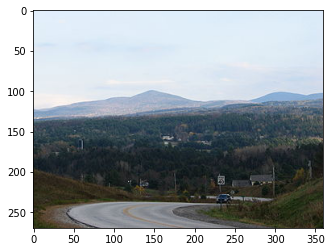

Fire : 0.00%  |Not Fire: 99.9%
No Fire detected





In [15]:
import os
from matplotlib import image as mpimg

dir_path = '/kaggle/input/fire-predict/'
for img in os.listdir(dir_path):
    file_path = dir_path+img
    
    #Display image
    mp_image = mpimg.imread(file_path)
    plt.imshow(mp_image)
    plt.show()
    
    preprocessed_image = prepare_image(file_path)
    predictions = model.predict(preprocessed_image)
    print("Fire :",str(predictions[0][0]*100)[:4] + "%"," |Not Fire:",str(predictions[0][1]*100)[:4]+"%")
    labels=(predictions>0.5).astype(int)
    if labels[0][0]==1 :
        print("Fire detected")
    else:
        print("No Fire detected")
    print("\n\n")    